In [1]:
import numpy as np
from scipy import linalg

import pandas as pd

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import gc

%matplotlib inline

In [2]:
sample = 128 #hz
trial_time = 3 #s #reference suggest 2s 2*128=256 > 2*100(max freq)=200 奈奎斯特采样定理

origin_channel = 5 #5 channel eeg

In [3]:
def cov_mat(X):
    return np.matmul(X , X.T)/np.trace(np.matmul(X , X.T))

#计算每种样本的平均协方差矩阵
def average_norm_cov_mat(data):
    count = data.shape[0]
    sum_mat = np.zeros(shape=(data[0].shape[0] , data[0].shape[0]))
    
    for i in range(count):
        sum_mat += cov_mat(data[i])
    
    return sum_mat/count

m = 2 #选取最高m个特征向量 m最小为1
def CSP_matrix(train_data_1 , train_data_2):
    #计算投影矩阵
    R_pink = average_norm_cov_mat(train_data_1)
    R_white = average_norm_cov_mat(train_data_2)
    
    R = R_pink + R_white
    
    eigenvalues , U0 = np.linalg.eig(R)

    sort_index = np.argsort(eigenvalues)
    sort_index = sort_index[:: -1]

    U0 = U0[: , sort_index]
    eigenvalues = sorted(eigenvalues , reverse=True)

    sigma = np.diag(eigenvalues)
    
    #白化矩阵
    P = np.matmul(np.diag(np.power(eigenvalues , -0.5)) , U0.T)
    
    S_pink = np.matmul(np.matmul(P , R_pink) , P.T)
    S_white = np.matmul(np.matmul(P , R_white) , P.T)
    
    E1 , US1 = np.linalg.eig(S_pink)
    E2 , US2 = np.linalg.eig(S_white)

    #E1+E2=I
    #US1=US2
    
    sort_index_1 = np.argsort(E1)
    sort_index_1 = sort_index_1[:: -1]
    
    E1 = sorted(E1 , reverse=True)
    US1 = US1[: , sort_index_1]
    
    W_1 = np.matmul(US1[: , 0:m].T , P) #前2列特征向量
    #=======================
    sort_index_2 = np.argsort(E2)
    sort_index_2 = sort_index_2[:: -1]
    
    E2 = sorted(E2 , reverse=True)
    US2 = US2[: , sort_index_2]
    
    W_2 = np.matmul(US2[: , 0:m].T , P) #前2列特征向量
    
    return W_1 , W_2


In [4]:
def load_data(file_name):
    #pink and white
    
    temp = pd.read_csv(file_name)
    
    #删除前3秒和后2秒数据
    temp = temp.iloc[ : temp.shape[0] - 2*sample] #后2秒 2s sample:128hz
    temp = temp.iloc[3*sample : ] #前3秒 3s sample:128hz
    temp = temp.reset_index(drop = True)
    
    #暂时不standard
    for column in temp.columns:
        temp[column] = (temp[column] - temp[column].mean())/temp[column].std() #norm
    
    #5 channels data
    return temp[['AF3' , 'T7','Pz' , 'T8' , 'AF4']]

def sep(one_data , label):
    train_data = []
    train_labels = []
    
    size = sample*trial_time
    
    for i in range(one_data.shape[0] - size):
        train_data.append(one_data.iloc[i : i+size].values) #add one train sample
        train_labels.append(label) #corresponding label
    
    return train_data , train_labels

#连接多个csv文件
def concat_eeg_csv(file_names):
    #concat a big csv file
    first_file = load_data(file_name = file_names[0])
    
    file_names.remove(file_names[0])
    
    for file_name in file_names:
        first_file = first_file.append(load_data(file_name = file_name) , ignore_index =  True)
    
    return first_file

In [8]:
def low_pass(data):
    point = 50 #highest freq = 50hz
    length = sample * trial_time #384 #原有注释为256
    
    #50:334
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            a = np.fft.fft(data[i][j]).real
            b = np.fft.fft(data[i][j]).imag
            a[point : length-point] = 0
            b[point : length-point] = 0
            #重建频谱
            new_freq = [np.complex(a[i] , b[i]) for i in range(length)]
            new_freq = np.array(new_freq)
            
            data[i][j] = np.fft.ifft(new_freq)
    
    print(point , length)
    return data

In [6]:
#data_1 = concat_eeg_csv(['raw_eeg/train_color1/white.csv' , 'raw_eeg/train_colorx/long_white_recording.csv' , 'raw_eeg/train_color2/white.csv' , 'raw_eeg/train_color3/white.csv'])
#data_2 = concat_eeg_csv(['raw_eeg/train_color1/pink.csv' , 'raw_eeg/train_colorx/long_pink_recording.csv' , 'raw_eeg/train_color2/pink.csv','raw_eeg/train_color3/pink.csv'])

#单一数据集时
color_2 = 'long_white_recording.csv'
color_1 = 'long_pink_recording.csv'
data_pink = load_data(file_name = '../raw_eeg/train_colorx/'+color_1)
data_white = load_data(file_name = '../raw_eeg/train_colorx/'+color_2)

train_data_1 , train_labels_1 = sep(data_pink , 0)
train_data_2 , train_labels_2 = sep(data_white , 1)

train_data_1 = np.array(train_data_1)
train_data_2 = np.array(train_data_2)

train_labels_1 = np.array(train_labels_1)
train_labels_2 = np.array(train_labels_2)

train_data_1 = np.transpose(train_data_1 , axes=(0 , 2 , 1))
train_data_2 = np.transpose(train_data_2 , axes=(0 , 2 , 1))


In [7]:
print(train_data_1.shape , train_data_2.shape)

(16656, 5, 384) (16860, 5, 384)


In [9]:
train_data_1 = low_pass(train_data_1)
train_data_2 = low_pass(train_data_2)

I:\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


50 384
50 384


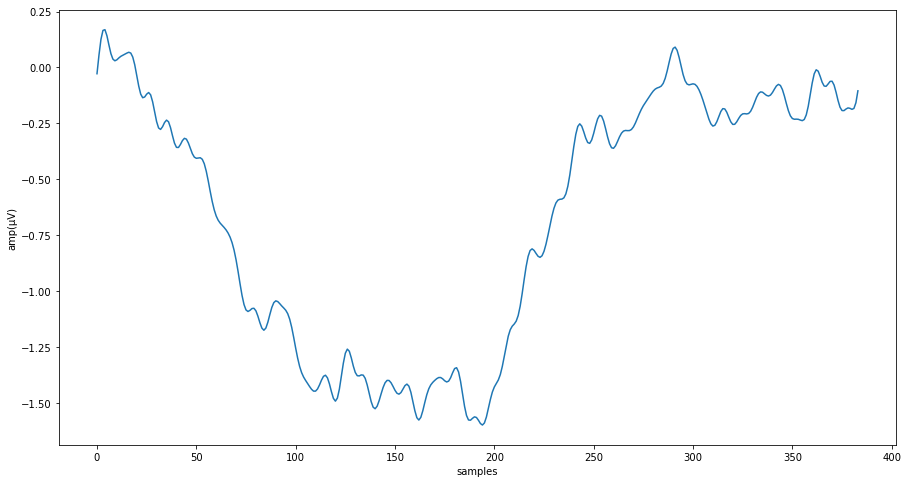

In [11]:
fig = plt.figure(figsize=(15,8))
plt.xlabel('samples')
plt.ylabel('amp(μV)')
#plt.title('origin data(after norm)')
#data_pink.AF3[:384].plot.line()
plt.plot(train_data_1[0][1])

In [10]:
point = 50
a = np.fft.fft(data_pink.AF3[:128*2]).real

a[point:256-point] = 0

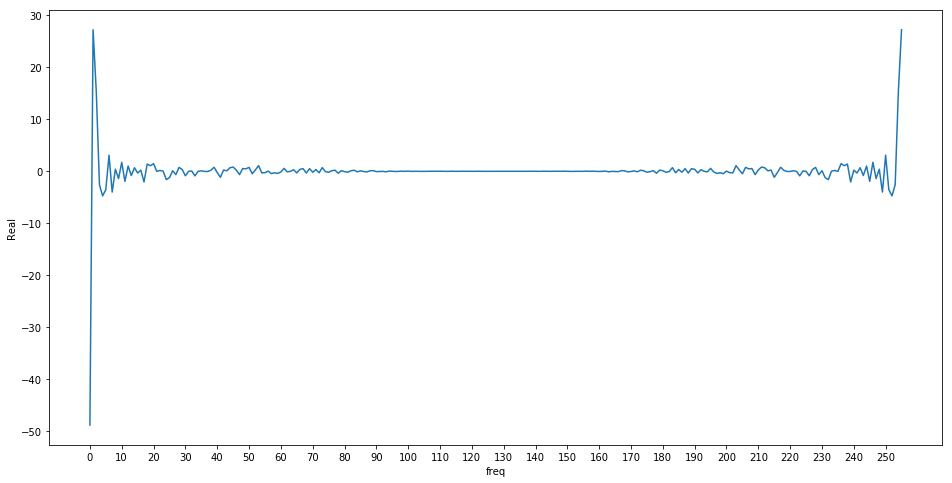

In [12]:
plt.figure(figsize=(16,8))
plt.xlabel('freq')
plt.ylabel('Real')
plt.xticks(np.arange(0 , 128*2 , 10))
plt.plot(np.arange(128*2) , np.fft.fft(data_pink.AF3[:128*2]).real)#np.abs(np.fft.fft(data_pink.AF3[:128*2]).real))

In [60]:
b = np.fft.fft(data_pink.AF3[:128*2]).imag
b[point:256-point] = 0

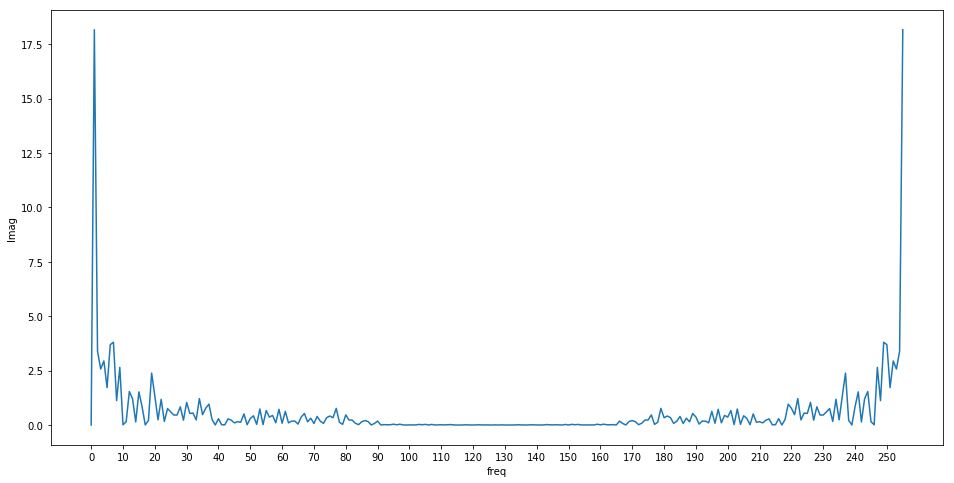

In [43]:
plt.figure(figsize=(16,8))
plt.xlabel('freq')
plt.ylabel('Imag')
plt.xticks(np.arange(0 , 128*2 , 10))
plt.plot(np.arange(128*2) , np.abs(np.fft.fft(data_pink.AF3[:128*2]).imag))

I:\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


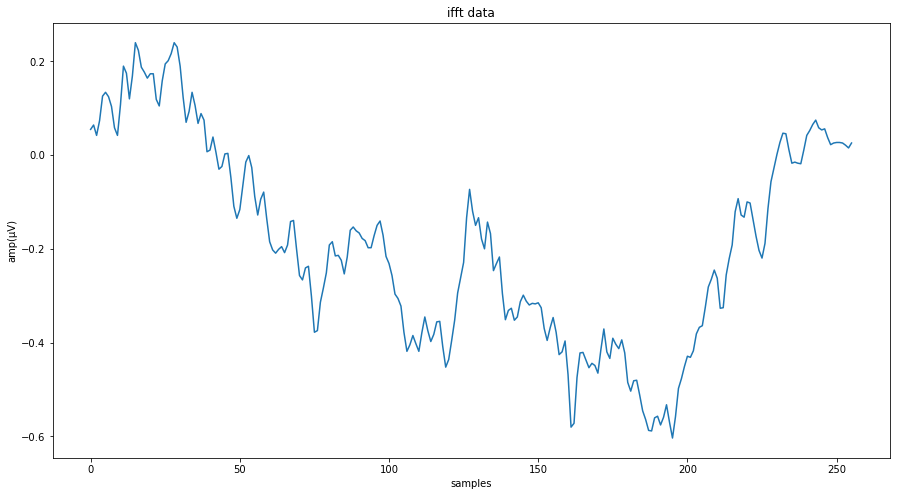

In [34]:
plt.figure(figsize=(15,8))
plt.xlabel('samples')
plt.ylabel('amp(μV)')
plt.title('ifft data')
plt.plot(np.arange(128*2) , np.fft.ifft(np.fft.fft(data_pink.AF3[:128*2])))

In [61]:
'''去掉一些频率'''
test = [np.complex(a[i] , b[i]) for i in range(256)]
test = np.array(test)
'''去掉一些频率'''

'去掉一些频率'

I:\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


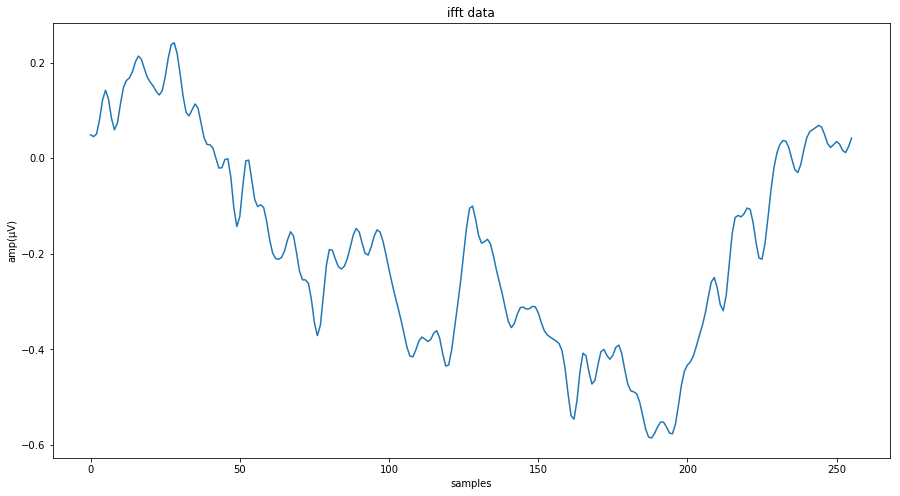

In [62]:
'''去高频后 变光滑了'''
plt.figure(figsize=(15,8))
plt.xlabel('samples')
plt.ylabel('amp(μV)')
plt.title('ifft data')
plt.plot(np.arange(128*2) , np.fft.ifft(test))
'''high pass'''

In [103]:
W_1 , W_2 = CSP_matrix(train_data_1 , train_data_2)

In [104]:
W_1

array([[-0.23010564,  0.03395917, -1.54431904,  0.09188226, -0.14277993],
       [ 0.18655948, -1.94463941,  0.4542372 , -0.40593002,  0.36189225]])

In [105]:
W_2

array([[ 1.68720648, -0.58898414, -1.13627797,  0.04773709,  0.22901149],
       [-1.06709621, -0.22838577, -0.6868113 , -0.59236466,  2.32412723]])

In [106]:
def fetch_feature(xi):
    #m = 2 #2*m features
    #
    #Z = np.matmul(W , xi)
    #
    #Z_pre_m = Z[0:m ,:]
    #Z_after_m = Z[-m: , :]
    #
    #Zp = np.concatenate((Z_pre_m , Z_after_m))
    #
    #sigma_var_Zp = 0
    #
    #for i in range(2*m):
    #    sigma_var_Zp += np.var(Zp[i])
    #    
    #fi = [np.log(np.var(Zpi)/sigma_var_Zp) for Zpi in Zp]
    #
    #fi = np.array(fi)
    
    #======
    #特征维数较低时 例如低于100
    #fi = np.concatenate([np.matmul(W_1 , xi) , np.matmul(W_2 , xi)])
    #======
    '''特征提取方式1'''
    z1 = np.matmul(W_1 , xi) #2*384
    z2 = np.matmul(W_2 , xi) #2*384
    return np.concatenate((z1 , z2))

    '''特征提取方式2'''
    #z1 = np.matmul(W_1 , xi) #2*384
    #z2 = np.matmul(W_2 , xi) #2*384
    #
    #var_z1_1 = np.var(z1 , axis = 1)[0]
    #var_z1_2 = np.var(z1 , axis = 1)[1]
    #var_z2_1 = np.var(z2 , axis = 1)[0]
    #var_z2_2 = np.var(z2 , axis = 1)[1]
    #
    #f1 = var_z1_1/(var_z1_1+var_z2_1)
    #f2 = var_z2_1/(var_z1_1+var_z2_1)
    #f3 = var_z1_2/(var_z1_2+var_z2_2)
    #f4 = var_z2_2/(var_z1_2+var_z2_2)
    #
    #return np.array([f1 , f2 , f3 , f4])


In [114]:
train_data = np.concatenate((train_data_1 , train_data_2))

train_labels = np.concatenate((train_labels_1 , train_labels_2))

train_data_features = []

In [115]:
for i in range(train_data.shape[0]):
    train_data_features.append(fetch_feature(train_data[i]))

train_data_features = np.array(train_data_features)

In [116]:
train_data_features.shape

(33516, 4, 384)

In [117]:
'''特征提取方式1使用'''
train_data_features = np.transpose(train_data_features , axes=(0 , 2 , 1))

In [ ]:
'''ANN不要特征合并'''
train_data_features = train_data_features.reshape(train_data_features.shape[0] , -1)

In [118]:
train_data_features.shape

(33516, 1536)

In [119]:
train_labels.shape

(33516,)

In [54]:
#kmeans = KMeans(n_clusters = 2)
#
#kmeans.fit(train_data_features , train_labels)
#
#plt.figure(figsize=(10,8))
#plt.scatter(train_data_features[: , 0] , train_data_features[: , 1] , c = kmeans.labels_)

In [55]:
#plt.figure(figsize=(10,8))
#plt.scatter(train_data_features[: , 2] , train_data_features[: , 3] , c = train_labels)

In [261]:
svc = SVC(verbose = True)
svc.fit(train_data_features , train_labels)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [262]:
svc.score(train_data_features , train_labels)

0.5922893323609362

In [120]:
rf = RandomForestClassifier(verbose=False , random_state = 52)

rf.fit(train_data_features , train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=52,
            verbose=False, warm_start=False)

In [121]:
rf.score(train_data_features , train_labels)

1.0

In [122]:
adaboost = AdaBoostClassifier(random_state=52)
adaboost.fit(train_data_features , train_labels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=52)

In [123]:
adaboost.score(train_data_features , train_labels)

0.9519930779329275

In [124]:
#==============
#==============
#val step
color_val_1 = 'white.csv'
color_val_2 = 'pink.csv'

data_1_val = load_data('../raw_eeg/val_color1/'+ color_val_1)
data_2_val = load_data('../raw_eeg/val_color1/'+ color_val_2)

val_data_1 , val_labels_1 = sep(data_1_val , 0)
val_data_2 , val_labels_2 = sep(data_2_val , 1)

val_data_1 = np.array(val_data_1)
val_data_2 = np.array(val_data_2)

val_labels_1 = np.array(val_labels_1)
val_labels_2 = np.array(val_labels_2)

val_data_1 = np.transpose(val_data_1 , axes=(0 , 2 , 1))
val_data_2 = np.transpose(val_data_2 , axes=(0 , 2 , 1))

val_data_1 = low_pass(val_data_1)
val_data_2 = low_pass(val_data_2)

#===================
#concat
val_data_features = []

val_data = np.concatenate((val_data_1 , val_data_2))
val_labels = np.concatenate((val_labels_1 , val_labels_2))

#===================
#fetch feature
for i in range(val_data.shape[0]):
    val_data_features.append(fetch_feature(val_data[i]))

val_data_features = np.array(val_data_features)

I:\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: ComplexWarning: Casting complex values to real discards the imaginary part


In [125]:
'''特征提取方式1需要'''
val_data_features = np.transpose(val_data_features , axes=(0 , 2 , 1))

In [126]:
val_data_features = val_data_features.reshape((val_data_features.shape[0] , -1))

In [127]:
val_data_features.shape

(12812, 1536)

In [77]:
#SVM
svc.score(val_data_features , val_labels)

NameError: name 'svc' is not defined

In [128]:
#RandomForest
rf.score(val_data_features , val_labels)

0.4671401810802373

In [129]:
adaboost.score(val_data_features , val_labels)

0.4784576959100843

In [51]:
val_data_features.shape

(13068, 4)